In [9]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import torch
from coherenceModel import *
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
paragraph_df = pd.read_csv('aviationPerms.csv')
paragraph_df

,paragraph,is_coherent
0,The preflight inspection of the fuel tanks by ...,1
1,"The pilot reported that he was cleared to 4,00...",1
2,The instrument-rated private pilot lost contro...,1
3,The non-instrument rated private pilot was rec...,1
4,The commercial pilot reported a partial power ...,1
...,...,...
2095,THE FUEL SELECTOR WAS POSITIONED ON THE RIGHT ...,0
2096,DURING AN INTENTIONAL MANEUVER TO AVOID A HOME...,0
2097,RESIDUAL FUEL WAS FOUND IN THE CARBURETOR BOWL...,0
2098,"AT A 75% POWER SETTING, FUEL FLOW IS ABOUT 10....",0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    paragraph_df.paragraph.values, 
    paragraph_df.is_coherent.values,
    stratify = paragraph_df.is_coherent.values,
    test_size = 0.1, 
    random_state = 487
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train,
    stratify = y_train,
    test_size = 0.2, 
    random_state = 487
)
print(X_train[0])
print(y_train[0])

Routine air work was performed and then touch-and-go landing practice was planned. The approach and landing on runway 34 was normal. During the takeoff roll the pilot noticed that unusual stick forces were required to raise the tail wheel. FAA inspectors examined the airplane and did not report finding any trim or control system irregularity; however, the fuselage distortion precluded a complete examination. He saw a row of sailplanes parked on runway 30 in his path and elected to turn off the runway into sagebrush and grass. He decided to abort the takeoff and applied forward stick to prevent the airplane from leaping off the runway in a stalled condition. The trim setting was rechecked and confirmed. The pilot added some additional nose down trim, but no relief of stick pressure was noticed. He was drifting to the right and approaching the intersection of runway 30 at this time. The right main landing gear fell into a ditch and collapsed, buckling and distorting the fuselage. Trim wa

In [4]:
embed = KeyedVectors.load('vectors.kv')

In [71]:
train_data = WindowedParDataset(X_train, y_train, embed, 5)
dev_data = WindowedParDataset(X_val, y_val, embed, 5)
test_data = WindowedParDataset(X_test, y_test, embed, 5)

In [72]:
train_loader = DataLoader(train_data, batch_size=25, collate_fn=basic_collate_fn, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=25, collate_fn=basic_collate_fn, shuffle=True)
test_loader = DataLoader(test_data, batch_size=25, collate_fn=basic_collate_fn, shuffle=False)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [73]:
num_pos = len(paragraph_df[paragraph_df["is_coherent"] == 1])
num_neg = len(paragraph_df[paragraph_df["is_coherent"] == 0])
pos_weight = torch.Tensor([num_neg / num_pos]).to(device)
pos_weight

tensor([20.], device='cuda:0')

------------------------ Start Training ------------------------
Epoch No. 1--Iteration No. 106-- batch loss = 0.9014
Validation accuracy: 0.6033
Validation loss: 1.2496
Epoch No. 2--Iteration No. 212-- batch loss = 3.4147
Validation accuracy: 0.5151
Validation loss: 1.5262
Epoch No. 3--Iteration No. 318-- batch loss = 0.5177
Validation accuracy: 0.8134
Validation loss: 0.8021
Epoch No. 4--Iteration No. 424-- batch loss = 0.7412
Validation accuracy: 0.8421
Validation loss: 0.7415
Epoch No. 5--Iteration No. 530-- batch loss = 0.3398
Validation accuracy: 0.8415
Validation loss: 0.7358
Epoch No. 6--Iteration No. 636-- batch loss = 0.7997
Validation accuracy: 0.8614
Validation loss: 0.6524
Epoch No. 7--Iteration No. 742-- batch loss = 0.3304
Validation accuracy: 0.8845
Validation loss: 0.5857
Epoch No. 8--Iteration No. 848-- batch loss = 0.1679
Validation accuracy: 0.8156
Validation loss: 0.6045
Epoch No. 9--Iteration No. 954-- batch loss = 0.1306
Validation accuracy: 0.9064
Validation los

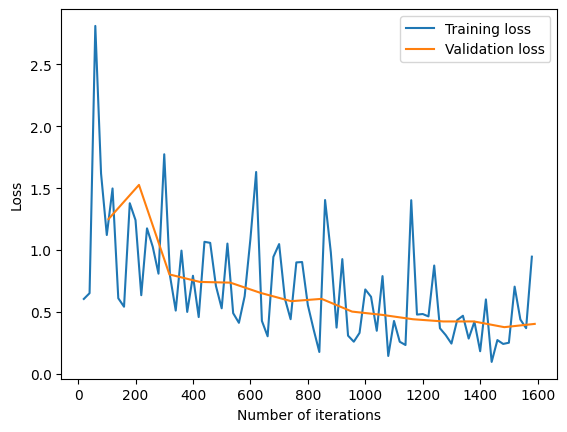

In [74]:
# test on validation to see if overfit is possible
ffnn = FFNN(200, 200, False, 5, device)
ffnn.to(device)
optim = get_optimizer(ffnn, lr=1e-2, weight_decay=0)
best_model, stats = train_model(ffnn, dev_loader, dev_loader, optim, pos_weight=pos_weight,
                                num_epoch=15, collect_cycle=20, device=device, patience=None)
plot_loss(stats)

In [ ]:
import itertools
from tqdm.notebook import tqdm

torch.cuda.empty_cache()

def search_param_utterance():
    """Experiemnt on different hyper parameters."""
    hidden_dim, learning_rate, weight_decay, window_sizes = get_hyper_parameters()
    print("hidden dimension from: {}\nlearning rate from: {}\nweight_decay from: {}\nwindow from: {}".format(
        hidden_dim, learning_rate, weight_decay, window_sizes
    ))
    best_model, best_stats = None, None
    best_accuracy, best_lr, best_wd, best_hd, best_window_size = 0, 0, 0, 0, 0
    for hd, lr, wd, window_size in tqdm(itertools.product(hidden_dim, learning_rate, weight_decay, window_sizes),
                           total=len(hidden_dim) * len(learning_rate) * len(weight_decay) * len(window_sizes)):
        net = FFNN(hd, 200, False, window_size, device).to(device)
        optim = get_optimizer(net, lr=lr, weight_decay=wd)
        model, stats = train_model(net, train_loader, dev_loader, optim, pos_weight=pos_weight, 
                                   num_epoch=200, collect_cycle=500, device=device, 
                                   verbose=True, patience=30)
        # print accuracy
        print(f"{(hd, lr, wd, window_size)}: {stats['accuracy']}")
        # update best parameters if needed
        if stats['accuracy'] > best_accuracy:
            best_accuracy = stats['accuracy']
            best_model, best_stats = model, stats
            best_hd, best_lr, best_wd, best_window_size = hd, lr, wd, window_size
            torch.save(best_model.state_dict(), 'best_rnn.pt')
    print("\n\nBest hidden dimension: {}, Best learning rate: {}, best weight_decay: {}, best window: {}".format(
        best_hd, best_lr, best_wd, best_window_size))
    print("Accuracy: {:.4f}".format(best_accuracy))
    plot_loss(best_stats)
    return best_model
basic_model = search_param_utterance()

hidden dimension from: [600]
learning rate from: [0.01]
weight_decay from: [0.01, 0.1, 0.25, 0.5, 1.0, 1.25, 2.0, 2.5, 5.0]
window from: [5]


  0%|          | 0/9 [00:00<?, ?it/s]

------------------------ Start Training ------------------------
Epoch No. 1--Iteration No. 422-- batch loss = 0.6847
Validation accuracy: 0.5000
Validation loss: 1.3190
Epoch No. 2--Iteration No. 844-- batch loss = 0.7036
Validation accuracy: 0.5000
Validation loss: 1.3194
Epoch No. 3--Iteration No. 1266-- batch loss = 0.7002
Validation accuracy: 0.5000
Validation loss: 1.3232
Epoch No. 4--Iteration No. 1688-- batch loss = 7.2465
Validation accuracy: 0.5000
Validation loss: 1.3196
Epoch No. 5--Iteration No. 2110-- batch loss = 0.6999
Validation accuracy: 0.5000
Validation loss: 1.3232
Epoch No. 6--Iteration No. 2532-- batch loss = 0.6916
Validation accuracy: 0.5371
Validation loss: 1.3190
Epoch No. 7--Iteration No. 2954-- batch loss = 0.6926
Validation accuracy: 0.5309
Validation loss: 1.3193
Epoch No. 8--Iteration No. 3376-- batch loss = 7.2446
Validation accuracy: 0.4877
Validation loss: 1.3348
Epoch No. 9--Iteration No. 3798-- batch loss = 0.6975
Validation accuracy: 0.4864
Validat